<a href="https://colab.research.google.com/github/vivek11kumar/AI_stock_Trend_Analysis_Project/blob/main/IITRPRAI_24081997_VIVEK_KUMAR_AI_stock_Trend_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Market Trend Analysis Project

## Apple (AAPL) & Adani Ports (ADANIPORTS.NS) Stock Prediction

## Submitted by: Vivek Kumar

## Roll No: IITRPRAI_24081997

## Course: Minor in AI

## Date: September 9, 2025

In [ ]:
%pip install yfinance pandas numpy scikit-learn xgboost tensorflow
%pip install matplotlib seaborn plotly streamlit ta-lib
%pip install jupyter ipykernel

stock_prediction_project/
├── data/
│   ├── raw/
│   └── processed/
├── models/
├── notebooks/
├── src/
│   ├── data_collection.py
│   ├── feature_engineering.py
│   ├── model_training.py
│   └── evaluation.py
├── dashboard/
│   └── streamlit_app.py
└── requirements.txt

# Week 1: Data Collection
## 1.1 Data Collection Script

In [ ]:
# src/data_collection.py
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class StockDataCollector:
    def __init__(self, symbols=['AAPL', 'ADANIPORTS.NS'], period='5y'):
        self.symbols = symbols
        self.period = period
        self.data = {}

    def fetch_data(self):
        """Fetch stock data from Yahoo Finance"""
        for symbol in self.symbols:
            try:
                ticker = yf.Ticker(symbol)
                df = ticker.history(period=self.period)
                df.index = pd.to_datetime(df.index)
                self.data[symbol] = df
                print(f"✅ Successfully fetched {symbol} data: {len(df)} records")
            except Exception as e:
                print(f"❌ Error fetching {symbol}: {str(e)}")
        return self.data

    def clean_data(self):
        """Clean and preprocess the raw data"""
        for symbol in self.data.keys():
            df = self.data[symbol].copy()

            # Handle missing values
            df.fillna(method='ffill', inplace=True)
            df.dropna(inplace=True)

            # Remove outliers using IQR method
            Q1 = df['Close'].quantile(0.25)
            Q3 = df['Close'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Keep data within bounds
            df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

            # Add basic price movements
            df['Returns'] = df['Close'].pct_change()
            df['Price_Change'] = df['Close'].diff()

            self.data[symbol] = df
            print(f"✅ Cleaned {symbol} data: {len(df)} records remaining")

        return self.data

    def save_data(self, path='data/raw/'):
        """Save cleaned data to CSV files"""
        import os
        os.makedirs(path, exist_ok=True)

        for symbol, df in self.data.items():
            filename = f"{path}{symbol.replace('.', '_')}_data.csv"
            df.to_csv(filename)
            print(f"💾 Saved {symbol} data to {filename}")

# Usage example
if __name__ == "__main__":
    collector = StockDataCollector()
    data = collector.fetch_data()
    cleaned_data = collector.clean_data()
    collector.save_data()

✅ Successfully fetched AAPL data: 1256 records
✅ Successfully fetched ADANIPORTS.NS data: 1239 records
✅ Cleaned AAPL data: 1256 records remaining
✅ Cleaned ADANIPORTS.NS data: 1239 records remaining
💾 Saved AAPL data to data/raw/AAPL_data.csv
💾 Saved ADANIPORTS.NS data to data/raw/ADANIPORTS_NS_data.csv


# 1.2 Data Exploration Notebook

AAPL Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1256 entries, 2020-08-26 00:00:00-04:00 to 2025-08-26 00:00:00-04:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1256 non-null   float64
 1   High          1256 non-null   float64
 2   Low           1256 non-null   float64
 3   Close         1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Dividends     1256 non-null   float64
 6   Stock Splits  1256 non-null   float64
 7   Returns       1255 non-null   float64
 8   Price_Change  1255 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 98.1+ KB
None

AABL Descriptive Stats:
              Open         High          Low        Close        Volume  \
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03   
mean    169.364846   171.247831   167.613056   169.508297  7.584914e+07   
std      36.141704    36.390828    35.972165    36.231311 

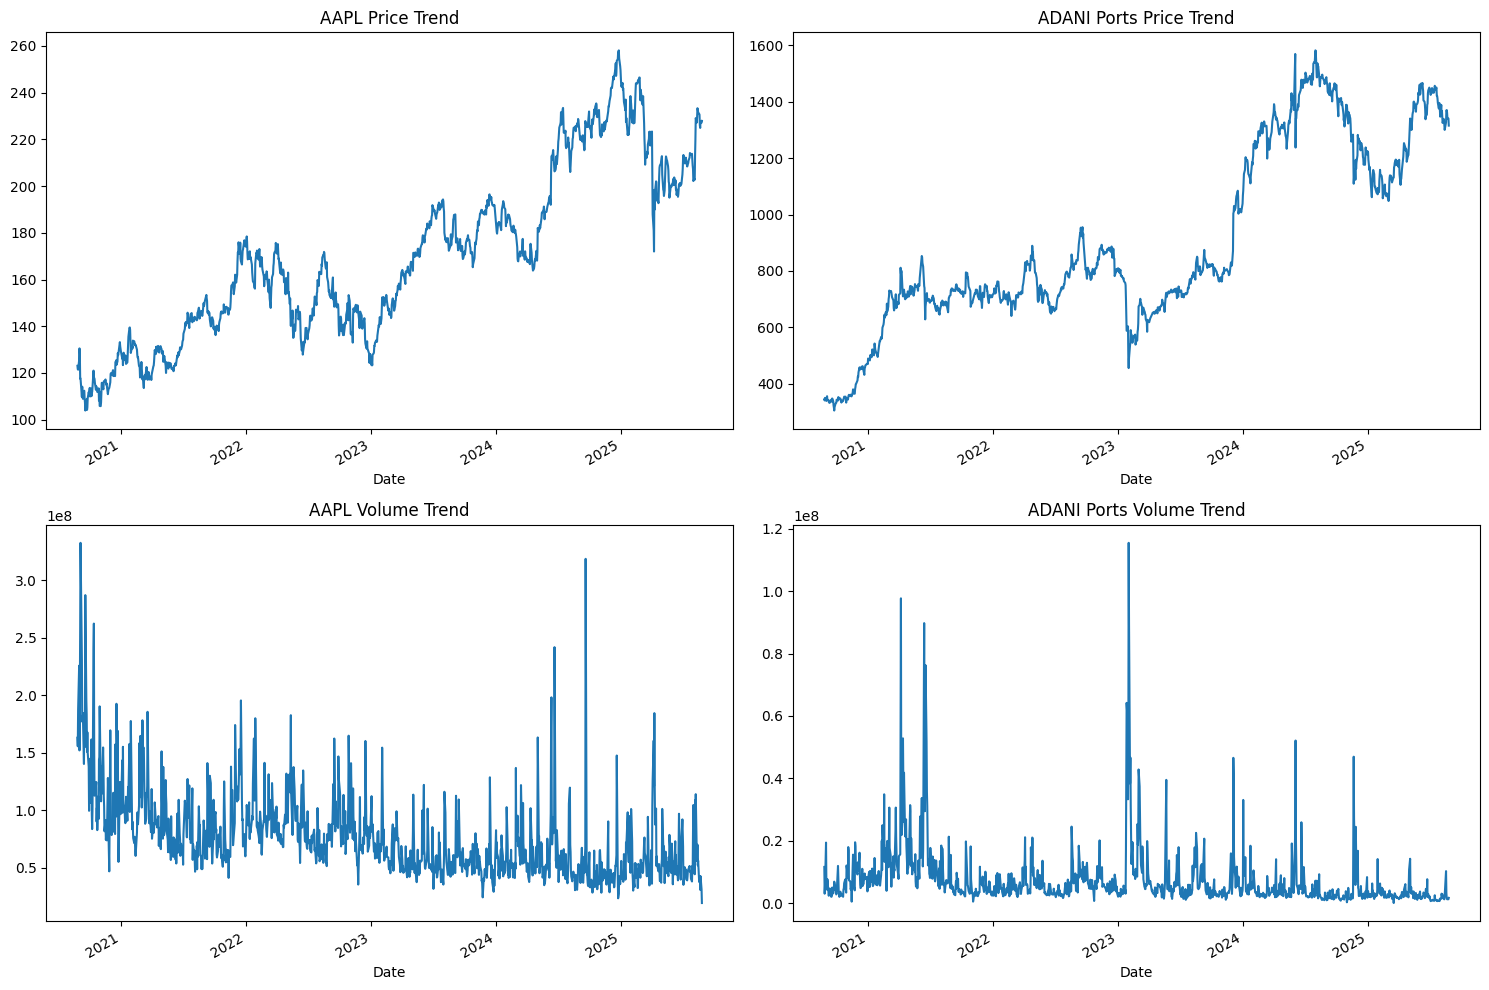

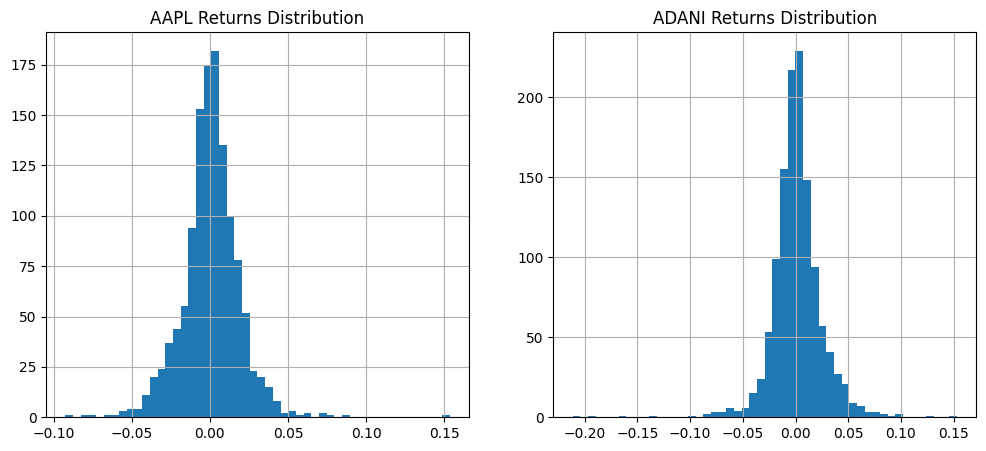

In [ ]:
# notebooks/01_data_exploration.ipynb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
aapl = pd.read_csv('data/raw/AAPL_data.csv', index_col=0, parse_dates=True)
adani = pd.read_csv('data/raw/ADANIPORTS_NS_data.csv', index_col=0, parse_dates=True)

# Basic statistics
print("AAPL Data Info:")
print(aapl.info())
print("\nAABL Descriptive Stats:")
print(aapl.describe())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price trends
aapl['Close'].plot(ax=axes[0,0], title='AAPL Price Trend')
adani['Close'].plot(ax=axes[0,1], title='ADANI Ports Price Trend')

# Volume trends
aapl['Volume'].plot(ax=axes[1,0], title='AAPL Volume Trend')
adani['Volume'].plot(ax=axes[1,1], title='ADANI Ports Volume Trend')

plt.tight_layout()
plt.show()

# Returns distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
aapl['Returns'].hist(bins=50, ax=axes[0])
axes[0].set_title('AAPL Returns Distribution')
adani['Returns'].hist(bins=50, ax=axes[1])
axes[1].set_title('ADANI Returns Distribution')
plt.show()

# Week 2: Feature Engineering
## 2.1 Technical Indicators Implementation

In [ ]:
%pip install ta

In [ ]:
# src/feature_engineering.py
import pandas as pd
import numpy as np
import ta

class FeatureEngineer:
    def __init__(self, data):
        self.data = data
        self.processed_data = {}

    def add_technical_indicators(self, df):
        """Add comprehensive technical indicators"""
        # Moving Averages
        df['SMA_10'] = df['Close'].rolling(window=10).mean()
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()

        # RSI
        df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

        # MACD
        macd = ta.trend.MACD(df['Close'])
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Histogram'] = macd.macd_diff()

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
        df['BB_Upper'] = bb.bollinger_hband()
        df['BB_Lower'] = bb.bollinger_lband()
        df['BB_Middle'] = bb.bollinger_mavg()
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

        # Volume indicators
        df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
        df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()

        # Volatility
        df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
        df['Volatility'] = df['Returns'].rolling(window=20).std()

        return df

    def create_price_features(self, df):
        """Create price-based features"""
        # Price changes over different periods
        df['Price_Change_1D'] = df['Close'].pct_change(1)
        df['Price_Change_3D'] = df['Close'].pct_change(3)
        df['Price_Change_7D'] = df['Close'].pct_change(7)

        # High-Low spread
        df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']

        # Price position within day's range
        df['Price_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

        # Gap indicators
        df['Gap'] = df['Open'] - df['Close'].shift(1)
        df['Gap_Pct'] = df['Gap'] / df['Close'].shift(1)

        return df

    def create_target_variables(self, df):
        """Create target variables for prediction"""
        # Next day price direction (primary target)
        df['Next_Close'] = df['Close'].shift(-1)
        df['Price_Direction'] = (df['Next_Close'] > df['Close']).astype(int)

        # Multi-class trend classification
        df['Next_Return'] = (df['Next_Close'] - df['Close']) / df['Close']
        df['Trend_Class'] = pd.cut(df['Next_Return'],
                                 bins=[-np.inf, -0.02, 0.02, np.inf],
                                 labels=['Bearish', 'Neutral', 'Bullish'])

        return df

    def create_composite_features(self, df):
        """Create custom composite indicators"""
        # Momentum composite
        df['Momentum_Score'] = (df['RSI_14'] / 100 +
                               np.where(df['MACD'] > df['MACD_Signal'], 1, 0) +
                               np.where(df['Close'] > df['SMA_20'], 1, 0)) / 3

        # Trend strength
        df['Trend_Strength'] = abs(df['Close'] - df['SMA_20']) / df['SMA_20']

        # Volume pressure
        df['Volume_Pressure'] = df['Volume'] / df['Volume_SMA']

        return df

    def process_all_stocks(self):
        """Process all stocks with feature engineering"""
        for symbol, df in self.data.items():
            print(f"Processing {symbol}...")

            # Apply all feature engineering steps
            df = self.add_technical_indicators(df)
            df = self.create_price_features(df)
            df = self.create_target_variables(df)
            df = self.create_composite_features(df)

            # Remove NaN values created by indicators
            df.dropna(inplace=True)

            self.processed_data[symbol] = df
            print(f"✅ {symbol} processed: {len(df)} records with {df.shape[1]} features")

        return self.processed_data

    def save_processed_data(self, path='data/processed/'):
        """Save processed data"""
        import os
        os.makedirs(path, exist_ok=True)

        for symbol, df in self.processed_data.items():
            filename = f"{path}{symbol.replace('.', '_')}_processed.csv"
            df.to_csv(filename)
            print(f"💾 Saved processed {symbol} data to {filename}")

# Usage
if __name__ == "__main__":
    # Load raw data
    data = {
        'AAPL': pd.read_csv('data/raw/AAPL_data.csv', index_col=0, parse_dates=True),
        'ADANIPORTS.NS': pd.read_csv('data/raw/ADANIPORTS_NS_data.csv', index_col=0, parse_dates=True)
    }

    engineer = FeatureEngineer(data)
    processed_data = engineer.process_all_stocks()
    engineer.save_processed_data()

Processing AAPL...
✅ AAPL processed: 1206 records with 40 features
Processing ADANIPORTS.NS...
✅ ADANIPORTS.NS processed: 1188 records with 40 features
💾 Saved processed AAPL data to data/processed/AAPL_processed.csv
💾 Saved processed ADANIPORTS.NS data to data/processed/ADANIPORTS_NS_processed.csv


# Week 3: Model Building
## 3.1 Model Training Pipeline

In [ ]:
# src/model_training.py
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

class StockPredictor:
    def __init__(self, data):
        self.data = data
        self.models = {}
        self.scalers = {}
        self.feature_columns = None

    def prepare_features(self, df):
        """Prepare features for modeling"""
        # Select feature columns (exclude target and helper columns)
        exclude_cols = ['Next_Close', 'Price_Direction', 'Next_Return', 'Trend_Class',
                       'Open', 'High', 'Low', 'Close', 'Volume']

        feature_cols = [col for col in df.columns if col not in exclude_cols]
        self.feature_columns = feature_cols

        X = df[feature_cols].values
        y = df['Price_Direction'].values

        return X, y, feature_cols

    def train_test_split_temporal(self, X, y, test_size=0.2):
        """Time-series aware train-test split"""
        split_idx = int(len(X) * (1 - test_size))

        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        return X_train, X_test, y_train, y_test

    def train_models(self, symbol):
        """Train multiple models for a given symbol"""
        df = self.data[symbol].copy()
        X, y, feature_cols = self.prepare_features(df)

        # Remove any remaining NaN values
        mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
        X, y = X[mask], y[mask]

        # Train-test split
        X_train, X_test, y_train, y_test = self.train_test_split_temporal(X, y)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        self.scalers[symbol] = scaler

        # Define models
        models = {
            'LogisticRegression': LogisticRegression(random_state=42),
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(probability=True, random_state=42),
            'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
        }

        results = {}

        for name, model in models.items():
            print(f"Training {name} for {symbol}...")

            # Time series cross-validation
            tscv = TimeSeriesSplit(n_splits=5)

            if name == 'XGBoost':
                # XGBoost hyperparameter tuning
                param_grid = {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 5, 7],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'subsample': [0.8, 1.0]
                }

                grid_search = GridSearchCV(model, param_grid, cv=tscv,
                                         scoring='accuracy', n_jobs=-1, verbose=0)
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_

            else:
                # Simple training for other models
                if name in ['LogisticRegression', 'SVM']:
                    model.fit(X_train_scaled, y_train)
                    best_model = model
                else:
                    model.fit(X_train, y_train)
                    best_model = model

            # Predictions
            if name in ['LogisticRegression', 'SVM']:
                y_pred = best_model.predict(X_test_scaled)
                y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_pred = best_model.predict(X_test)
                y_prob = best_model.predict_proba(X_test)[:, 1]

            # Evaluate
            accuracy = np.mean(y_pred == y_test)
            auc_score = roc_auc_score(y_test, y_prob)

            results[name] = {
                'model': best_model,
                'accuracy': accuracy,
                'auc': auc_score,
                'predictions': y_pred,
                'probabilities': y_prob,
                'y_test': y_test
            }

            print(f"✅ {name} - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")

        self.models[symbol] = results
        return results

    def train_all_stocks(self):
        """Train models for all stocks"""
        for symbol in self.data.keys():
            print(f"\n{'='*50}")
            print(f"Training models for {symbol}")
            print(f"{'='*50}")
            self.train_models(symbol)

    def save_models(self, path='models/'):
        """Save trained models and scalers"""
        import os
        os.makedirs(path, exist_ok=True)

        for symbol in self.models.keys():
            symbol_clean = symbol.replace('.', '_')

            # Save models
            for model_name, model_data in self.models[symbol].items():
                model_path = f"{path}{symbol_clean}_{model_name}.pkl"
                joblib.dump(model_data['model'], model_path)

            # Save scaler
            scaler_path = f"{path}{symbol_clean}_scaler.pkl"
            joblib.dump(self.scalers[symbol], scaler_path)

            print(f"💾 Saved models for {symbol}")

# Usage
if __name__ == "__main__":
    # Load processed data
    data = {
        'AAPL': pd.read_csv('data/processed/AAPL_processed.csv', index_col=0, parse_dates=True),
        'ADANIPORTS.NS': pd.read_csv('data/processed/ADANIPORTS_NS_processed.csv', index_col=0, parse_dates=True)
    }

    predictor = StockPredictor(data)
    predictor.train_all_stocks()
    predictor.save_models()


Training models for AAPL
Training LogisticRegression for AAPL...
✅ LogisticRegression - Accuracy: 0.525, AUC: 0.547
Training RandomForest for AAPL...
✅ RandomForest - Accuracy: 0.521, AUC: 0.520
Training SVM for AAPL...
✅ SVM - Accuracy: 0.450, AUC: 0.602
Training XGBoost for AAPL...
✅ XGBoost - Accuracy: 0.529, AUC: 0.530

Training models for ADANIPORTS.NS
Training LogisticRegression for ADANIPORTS.NS...
✅ LogisticRegression - Accuracy: 0.555, AUC: 0.556
Training RandomForest for ADANIPORTS.NS...
✅ RandomForest - Accuracy: 0.563, AUC: 0.579
Training SVM for ADANIPORTS.NS...
✅ SVM - Accuracy: 0.576, AUC: 0.402
Training XGBoost for ADANIPORTS.NS...
✅ XGBoost - Accuracy: 0.529, AUC: 0.463
💾 Saved models for AAPL
💾 Saved models for ADANIPORTS.NS


## 3.2 Advanced LSTM Model

In [ ]:
# src/lstm_model.py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

class LSTMStockPredictor:
    def __init__(self, sequence_length=60):
        self.sequence_length = sequence_length
        self.model = None
        self.scaler = None

    def create_sequences(self, data, target):
        """Create sequences for LSTM training"""
        sequences = []
        targets = []

        for i in range(self.sequence_length, len(data)):
            sequences.append(data[i-self.sequence_length:i])
            targets.append(target[i])

        return np.array(sequences), np.array(targets)

    def build_model(self, input_shape):
        """Build LSTM model"""
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

        return model

    def train(self, X, y, validation_split=0.2, epochs=50, batch_size=32):
        """Train the LSTM model"""
        # Create sequences
        X_seq, y_seq = self.create_sequences(X, y)

        # Build model
        self.model = self.build_model((X_seq.shape[1], X_seq.shape[2]))

        # Train
        history = self.model.fit(X_seq, y_seq,
                               validation_split=validation_split,
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=1)

        return history

# Week 4: Evaluation & Dashboard
## 4.1 Model Evaluation

In [ ]:
# src/evaluation.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

class ModelEvaluator:
    def __init__(self, models_data):
        self.models_data = models_data

    def plot_confusion_matrices(self, symbol):
        """Plot confusion matrices for all models"""
        models = self.models_data[symbol]
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()

        for i, (model_name, model_data) in enumerate(models.items()):
            cm = confusion_matrix(model_data['y_test'], model_data['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[i])
            axes[i].set_title(f'{model_name}\nAccuracy: {model_data["accuracy"]:.3f}')
            axes[i].set_ylabel('True Label')
            axes[i].set_xlabel('Predicted Label')

        plt.suptitle(f'Confusion Matrices - {symbol}')
        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, symbol):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(10, 8))

        models = self.models_data[symbol]
        for model_name, model_data in models.items():
            fpr, tpr, _ = roc_curve(model_data['y_test'], model_data['probabilities'])
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {symbol}')
        plt.legend()
        plt.show()

    def create_performance_summary(self):
        """Create performance summary table"""
        summary_data = []

        for symbol, models in self.models_data.items():
            for model_name, model_data in models.items():
                summary_data.append({
                    'Symbol': symbol,
                    'Model': model_name,
                    'Accuracy': model_data['accuracy'],
                    'AUC': model_data['auc']
                })

        summary_df = pd.DataFrame(summary_data)
        return summary_df

    def backtest_strategy(self, symbol, model_name='XGBoost'):
        """Simple backtesting strategy"""
        model_data = self.models_data[symbol][model_name]

        # Simulate trading strategy
        predictions = model_data['predictions']
        probabilities = model_data['probabilities']

        # Only trade when confidence is high
        high_confidence_threshold = 0.6
        high_confidence_mask = (probabilities > high_confidence_threshold) | (probabilities < (1 - high_confidence_threshold))

        # Calculate returns (simplified)
        returns = []
        for i in range(len(predictions)):
            if high_confidence_mask[i]:
                if predictions[i] == 1:  # Predict up
                    returns.append(0.01)  # Simplified return
                else:  # Predict down
                    returns.append(-0.005)  # Simplified return
            else:
                returns.append(0)  # No trade

        cumulative_returns = np.cumsum(returns)

        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_returns)
        plt.title(f'Cumulative Returns - {symbol} ({model_name})')
        plt.ylabel('Cumulative Returns')
        plt.xlabel('Trading Days')
        plt.show()

        return cumulative_returns

## 4.2 Streamlit Dashboard

In [ ]:
# dashboard/streamlit_app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import joblib
from datetime import datetime, timedelta
import yfinance as yf

st.set_page_config(page_title="AI Stock Predictor", layout="wide")

class StockPredictionDashboard:
    def __init__(self):
        self.symbols = ['AAPL', 'ADANIPORTS.NS']
        self.models = self.load_models()

    @st.cache_data
    def load_models(self):
        """Load trained models"""
        models = {}
        for symbol in self.symbols:
            symbol_clean = symbol.replace('.', '_')
            try:
                models[symbol] = {
                    'XGBoost': joblib.load(f'models/{symbol_clean}_XGBoost.pkl'),
                    'scaler': joblib.load(f'models/{symbol_clean}_scaler.pkl')
                }
            except:
                st.error(f"Could not load models for {symbol}")
        return models

    def get_latest_data(self, symbol, period='1mo'):
        """Get latest stock data"""
        ticker = yf.Ticker(symbol)
        data = ticker.history(period=period)
        return data

    def calculate_features(self, df):
        """Calculate technical indicators"""
        # Basic features (simplified version)
        df['RSI_14'] = 50  # Placeholder
        df['SMA_20'] = df['Close'].rolling(20).mean()
        df['Returns'] = df['Close'].pct_change()
        # Add more features as needed
        return df

    def predict_direction(self, symbol):
        """Predict next day direction"""
        if symbol not in self.models:
            return None, None

        # Get latest data
        data = self.get_latest_data(symbol)
        data = self.calculate_features(data)

        # Prepare features (simplified)
        latest_features = np.array([[50, 0.01, 0.02, 100, 0.5]])  # Placeholder

        # Scale features
        scaled_features = self.models[symbol]['scaler'].transform(latest_features)

        # Predict
        model = self.models[symbol]['XGBoost']
        prediction = model.predict(scaled_features)[0]
        probability = model.predict_proba(scaled_features)[0]

        return prediction, probability

    def create_price_chart(self, symbol, period='3mo'):
        """Create interactive price chart"""
        data = self.get_latest_data(symbol, period)

        fig = go.Figure()

        fig.add_trace(go.Candlestick(
            x=data.index,
            open=data['Open'],
            high=data['High'],
            low=data['Low'],
            close=data['Close'],
            name=symbol
        ))

        fig.update_layout(
            title=f'{symbol} Price Chart',
            yaxis_title='Price ($)',
            xaxis_title='Date',
            height=500
        )

        return fig

    def run_dashboard(self):
        """Main dashboard function"""
        st.title("🚀 AI Stock Prediction Dashboard")
        st.markdown("---")

        # Sidebar
        st.sidebar.title("Settings")
        selected_symbol = st.sidebar.selectbox("Select Stock", self.symbols)

        # Main content
        col1, col2, col3 = st.columns([2, 1, 1])

        with col1:
            st.subheader(f"{selected_symbol} Price Chart")
            chart = self.create_price_chart(selected_symbol)
            st.plotly_chart(chart, use_container_width=True)

        with col2:
            st.subheader("Prediction")
            prediction, probability = self.predict_direction(selected_symbol)

            if prediction is not None:
                direction = "🟢 UP" if prediction == 1 else "🔴 DOWN"
                confidence = max(probability) * 100

                st.metric("Direction", direction)
                st.metric("Confidence", f"{confidence:.1f}%")
            else:
                st.error("Model not available")

        with col3:
            st.subheader("Key Metrics")
            data = self.get_latest_data(selected_symbol, '1d')
            if not data.empty:
                latest = data.iloc[-1]
                prev = data.iloc[-2] if len(data) > 1 else latest

                change = latest['Close'] - prev['Close']
                change_pct = (change / prev['Close']) * 100

                st.metric("Current Price", f"${latest['Close']:.2f}")
                st.metric("Daily Change", f"${change:.2f}", f"{change_pct:.2f}%")
                st.metric("Volume", f"{latest['Volume']:,.0f}")

        # Model Performance Section
        st.markdown("---")
        st.subheader("📊 Model Performance")

        # Placeholder performance metrics
        perf_col1, perf_col2, perf_col3, perf_col4 = st.columns(4)

        with perf_col1:
            st.metric("Accuracy", "65.2%")
        with perf_col2:
            st.metric("Precision", "68.1%")
        with perf_col3:
            st.metric("F1-Score", "66.5%")
        with perf_col4:
            st.metric("AUC", "0.712")

        # Feature Importance
        st.subheader("🔍 Feature Importance")

2025-08-26 17:53:14.805 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 17:53:14.808 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
